In [1]:
import glob
import numpy as np
import codecs
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
def find_nearest_index(samples, targets):
    nearest_index_list = []
    for target in targets:
        differences = np.abs(samples - target)
        nearest_index = np.argmin(differences)
        nearest_index_list.append(nearest_index)
    return nearest_index_list

In [13]:
# initialize constants
tab_char = '\t'
indentation_char = '\r\n'
delimiter = ''
num_samples_per_data = 6887

# initialize variables
peak_table_start_row_index = 0
peak_table_end_row_index = 0
composed_result_start_row_index = 0
composed_result_end_row_index = 0
wave_start_row_index = 0
wave_end_row_index = 0

data_dir = './gas-chromatograph-txt'
file_ext = '.TXT'
monthly_dir_list = glob.glob(data_dir + '/*')
filepath_list = []
for monthly_dir in monthly_dir_list:
    filepath_list += glob.glob(monthly_dir + '/*' + file_ext)
    
intensities_list = []
labels_list = []
for filepath in tqdm(filepath_list):
#     print('filepath -> {}'.format(filepath))
    df = pd.read_csv(
        filepath, 
        sep='\t',
        names=["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10"],
        encoding='cp932'
    )
#     display(df.head())
    wave_start_index = df.query('c1 == "R.Time"').index.values[0]
    wave_df = pd.DataFrame(
        df[['c1', 'c2']][wave_start_index+1:-3].values,
        columns=df.loc[wave_start_index, ['c1', 'c2']].values
    )
#     display(wave_df)
    peak_table_start_index = df.query('c1 == "[Peak Table (Ch1)]"').index.values[0]
    peak_table_end_index = df.query('c1 == "[Compound Results (Ch1)]"').index.values[0]
#     print('peak_table_end_index - peak_table_start_index -> {}'.format(peak_table_end_index - peak_table_start_index))
    if peak_table_end_index - peak_table_start_index <= 2:
        continue
    peak_df = pd.DataFrame(
        df[peak_table_start_index+3:peak_table_end_index].values,
        columns=df.loc[peak_table_start_index+2].values
    )
#     display(peak_df)
    times = wave_df['R.Time'].values.astype(float)
    intensities = wave_df['Intensity'].values.astype(float)
#     plt.figure(figsize=(16,4))
#     plt.plot(times, intensities)
    peak_start_times = [float(time) for time in peak_df['I.Time']]
    peak_start_index_list = find_nearest_index(times, peak_start_times)
    for peak_start_index, peak_start_time in zip(peak_start_index_list, peak_start_times):
#         print('peak start time (from peak table) -> {}'.format(peak_start_time))
        differences = np.abs(times - peak_start_time)
#         print('peak start time -> {}'.format(times[peak_start_index]))
#         plt.axvline(x=times[peak_start_index], color='red')
#     plt.show()
    labels = np.zeros(times.shape[0])
    labels[peak_start_index_list] = 1
    if len(intensities) == num_samples_per_data:
        intensities_list.append(intensities)
        labels_list.append(labels)
intensities_array = np.array(intensities_list)
labels_array = np.array(labels_list)

100%|██████████| 925/925 [00:27<00:00, 33.30it/s]


In [14]:
intensities_array.shape

(898, 6887)

In [5]:
def preprocess(samples, labels):
    window_length = 101
    num_samples = samples.shape[0]
    maximum = num_samples - np.floor(window_length/2)
    minimum = np.floor(window_length/2)
    label_index = int((maximum - minimum) * np.random.rand() + minimum)
    return samples[int(label_index-np.floor(window_length/2)):int(label_index+np.floor(window_length/2))], labels[label_index]

In [587]:
for i in range(10000):
    samples = intensities_array[0]
    labels = labels_array[0]
    cropped_samples, label = preprocess(samples, labels)
    if label==1:
        print(cropped_samples, label)

In [15]:
window_length = 101
dataset = tf.data.Dataset.from_tensor_slices((intensities_array, labels_array))
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
num_samples = intensities_array.shape[0]
steps_per_epoch = np.ceil(num_samples/BATCH_SIZE)
# dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(buffer_size=num_samples)
dataset = dataset.repeat()
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
sample_size = intensities_array[0].shape[0]
model = tf.keras.Sequential([
    tf.keras.layers.Dense(sample_size, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(sample_size, activation='sigmoid')
])
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='binary_crossentropy',
    metrics=["accuracy"]
)


In [17]:
model.fit(dataset, epochs=1000, steps_per_epoch=steps_per_epoch)

Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



29/29 [==============================] - 11s 374ms/step - loss: 74.2373 - accuracy: 0.0528
Epoch 2/1000
29/29 [==============================] - 12s 425ms/step - loss: 0.6730 - accuracy: 0.2209
Epoch 3/1000
29/29 [==============================] - 11s 382ms/step - loss: 0.6592 - accuracy: 0.2231
Epoch 4/1000
29/29 [==============================] - 10s 357ms/step - loss: 0.6456 - accuracy: 0.2177
Epoch 5/1000
29/29 [==============================] - 10s 349ms/step - loss: 0.6322 - accuracy: 0.2241
Epoch 6/1000
29/29 [==============================] - 9s 312ms/step - loss: 0.6195 - accuracy: 0.2144
Epoch 7/1000
29/29 [==============================] - 9s 315ms/step - loss: 0.6065 - accuracy: 0.2058
Epoch 8/1000
29/29 [==============================] - 10s 333ms/step - loss: 0.5945 - accuracy: 0.2306
Epoch 9/1000
29/29 [==============================] - 9s 317ms/step - loss: 0.5820 - accuracy: 0.2112
Epoch 10/1000
29/29 [==============================] - 12s 397ms/step - loss: 0.5701 - a

29/29 [==============================] - 8s 283ms/step - loss: 0.1588 - accuracy: 0.2069
Epoch 81/1000
29/29 [==============================] - 9s 294ms/step - loss: 0.1564 - accuracy: 0.2112
Epoch 82/1000
29/29 [==============================] - 8s 291ms/step - loss: 0.1540 - accuracy: 0.2209
Epoch 83/1000
29/29 [==============================] - 8s 285ms/step - loss: 0.1515 - accuracy: 0.2338
Epoch 84/1000
29/29 [==============================] - 8s 286ms/step - loss: 0.1492 - accuracy: 0.2058
Epoch 85/1000
29/29 [==============================] - 8s 289ms/step - loss: 0.1469 - accuracy: 0.2317
Epoch 86/1000
29/29 [==============================] - 8s 290ms/step - loss: 0.1446 - accuracy: 0.2155
Epoch 87/1000
29/29 [==============================] - 8s 290ms/step - loss: 0.1424 - accuracy: 0.2144
Epoch 88/1000
29/29 [==============================] - 8s 288ms/step - loss: 0.1402 - accuracy: 0.2198
Epoch 89/1000
29/29 [==============================] - 9s 323ms/step - loss: 0.1381 - a

29/29 [==============================] - 15s 514ms/step - loss: 0.0530 - accuracy: 0.2155
Epoch 159/1000
29/29 [==============================] - 15s 507ms/step - loss: 0.0523 - accuracy: 0.2198
Epoch 160/1000
29/29 [==============================] - 14s 496ms/step - loss: 0.0518 - accuracy: 0.2231
Epoch 161/1000
29/29 [==============================] - 17s 578ms/step - loss: 0.0511 - accuracy: 0.2047
Epoch 162/1000
29/29 [==============================] - 15s 529ms/step - loss: 0.0504 - accuracy: 0.2381
Epoch 163/1000
29/29 [==============================] - 14s 494ms/step - loss: 0.0498 - accuracy: 0.2252
Epoch 164/1000
29/29 [==============================] - 14s 499ms/step - loss: 0.0492 - accuracy: 0.2123
Epoch 165/1000
29/29 [==============================] - 15s 505ms/step - loss: 0.0486 - accuracy: 0.2198
Epoch 166/1000
29/29 [==============================] - 15s 504ms/step - loss: 0.0480 - accuracy: 0.2295
Epoch 167/1000
29/29 [==============================] - 14s 495ms/step

29/29 [==============================] - 9s 296ms/step - loss: 0.0215 - accuracy: 0.2274
Epoch 237/1000
29/29 [==============================] - 8s 292ms/step - loss: 0.0213 - accuracy: 0.2220
Epoch 238/1000
29/29 [==============================] - 9s 299ms/step - loss: 0.0211 - accuracy: 0.2144
Epoch 239/1000
29/29 [==============================] - 8s 293ms/step - loss: 0.0209 - accuracy: 0.2198
Epoch 240/1000
29/29 [==============================] - 9s 297ms/step - loss: 0.0207 - accuracy: 0.2220
Epoch 241/1000
29/29 [==============================] - 8s 287ms/step - loss: 0.0205 - accuracy: 0.2209
Epoch 242/1000
29/29 [==============================] - 8s 292ms/step - loss: 0.0203 - accuracy: 0.2241
Epoch 243/1000
29/29 [==============================] - 9s 294ms/step - loss: 0.0200 - accuracy: 0.2188
Epoch 244/1000
29/29 [==============================] - 9s 302ms/step - loss: 0.0198 - accuracy: 0.2144
Epoch 245/1000
29/29 [==============================] - 8s 288ms/step - loss: 0

29/29 [==============================] - 10s 343ms/step - loss: 0.0105 - accuracy: 0.2080
Epoch 315/1000
29/29 [==============================] - 9s 309ms/step - loss: 0.0104 - accuracy: 0.2166
Epoch 316/1000
29/29 [==============================] - 8s 289ms/step - loss: 0.0102 - accuracy: 0.2284
Epoch 317/1000
29/29 [==============================] - 9s 296ms/step - loss: 0.0103 - accuracy: 0.2263
Epoch 318/1000
29/29 [==============================] - 10s 354ms/step - loss: 0.0101 - accuracy: 0.2047
Epoch 319/1000
29/29 [==============================] - 10s 332ms/step - loss: 0.0101 - accuracy: 0.2166
Epoch 320/1000
29/29 [==============================] - 9s 326ms/step - loss: 0.0100 - accuracy: 0.2306
Epoch 321/1000
29/29 [==============================] - 9s 296ms/step - loss: 0.0100 - accuracy: 0.2155
Epoch 322/1000
29/29 [==============================] - 11s 366ms/step - loss: 0.0098 - accuracy: 0.2371
Epoch 323/1000
29/29 [==============================] - 10s 349ms/step - lo

29/29 [==============================] - 8s 284ms/step - loss: 0.0063 - accuracy: 0.2252
Epoch 393/1000
29/29 [==============================] - 8s 279ms/step - loss: 0.0063 - accuracy: 0.2252
Epoch 394/1000
29/29 [==============================] - 8s 288ms/step - loss: 0.0063 - accuracy: 0.2134
Epoch 395/1000
29/29 [==============================] - 8s 284ms/step - loss: 0.0063 - accuracy: 0.2295
Epoch 396/1000
29/29 [==============================] - 8s 286ms/step - loss: 0.0062 - accuracy: 0.2123
Epoch 397/1000
29/29 [==============================] - 10s 359ms/step - loss: 0.0061 - accuracy: 0.2349
Epoch 398/1000
29/29 [==============================] - 10s 354ms/step - loss: 0.0062 - accuracy: 0.2101
Epoch 399/1000
29/29 [==============================] - 9s 312ms/step - loss: 0.0062 - accuracy: 0.2220
Epoch 400/1000
29/29 [==============================] - 12s 407ms/step - loss: 0.0061 - accuracy: 0.2177
Epoch 401/1000
29/29 [==============================] - 12s 409ms/step - los

29/29 [==============================] - 11s 387ms/step - loss: 0.0047 - accuracy: 0.2306
Epoch 471/1000
29/29 [==============================] - 9s 301ms/step - loss: 0.0048 - accuracy: 0.2188
Epoch 472/1000
29/29 [==============================] - 12s 415ms/step - loss: 0.0047 - accuracy: 0.2241
Epoch 473/1000
29/29 [==============================] - 10s 356ms/step - loss: 0.0047 - accuracy: 0.2144
Epoch 474/1000
29/29 [==============================] - 9s 315ms/step - loss: 0.0047 - accuracy: 0.2317
Epoch 475/1000
29/29 [==============================] - 9s 309ms/step - loss: 0.0048 - accuracy: 0.2166
Epoch 476/1000
29/29 [==============================] - 10s 334ms/step - loss: 0.0047 - accuracy: 0.2188
Epoch 477/1000
29/29 [==============================] - 9s 321ms/step - loss: 0.0047 - accuracy: 0.2198
Epoch 478/1000
29/29 [==============================] - 10s 329ms/step - loss: 0.0047 - accuracy: 0.2241
Epoch 479/1000
29/29 [==============================] - 9s 302ms/step - lo

29/29 [==============================] - 8s 288ms/step - loss: 0.0042 - accuracy: 0.2166
Epoch 549/1000
29/29 [==============================] - 8s 288ms/step - loss: 0.0042 - accuracy: 0.2252
Epoch 550/1000
29/29 [==============================] - 8s 292ms/step - loss: 0.0041 - accuracy: 0.2080
Epoch 551/1000
29/29 [==============================] - 9s 302ms/step - loss: 0.0041 - accuracy: 0.2134
Epoch 552/1000
29/29 [==============================] - 8s 285ms/step - loss: 0.0042 - accuracy: 0.2274
Epoch 553/1000
29/29 [==============================] - 9s 297ms/step - loss: 0.0041 - accuracy: 0.2220
Epoch 554/1000
29/29 [==============================] - 8s 289ms/step - loss: 0.0041 - accuracy: 0.2252
Epoch 555/1000
29/29 [==============================] - 8s 288ms/step - loss: 0.0041 - accuracy: 0.2134
Epoch 556/1000
29/29 [==============================] - 8s 285ms/step - loss: 0.0042 - accuracy: 0.2241
Epoch 557/1000
29/29 [==============================] - 8s 291ms/step - loss: 0

29/29 [==============================] - 8s 293ms/step - loss: 0.0039 - accuracy: 0.2295
Epoch 627/1000
29/29 [==============================] - 9s 295ms/step - loss: 0.0039 - accuracy: 0.2080
Epoch 628/1000
29/29 [==============================] - 8s 288ms/step - loss: 0.0039 - accuracy: 0.2252
Epoch 629/1000
29/29 [==============================] - 9s 298ms/step - loss: 0.0039 - accuracy: 0.2188
Epoch 630/1000
29/29 [==============================] - 9s 295ms/step - loss: 0.0039 - accuracy: 0.2166
Epoch 631/1000
29/29 [==============================] - 11s 364ms/step - loss: 0.0039 - accuracy: 0.2209
Epoch 632/1000
29/29 [==============================] - 12s 412ms/step - loss: 0.0039 - accuracy: 0.2231
Epoch 633/1000
29/29 [==============================] - 9s 308ms/step - loss: 0.0039 - accuracy: 0.2134
Epoch 634/1000
29/29 [==============================] - 10s 348ms/step - loss: 0.0039 - accuracy: 0.2220
Epoch 635/1000
29/29 [==============================] - 10s 360ms/step - los

29/29 [==============================] - 12s 400ms/step - loss: 0.0037 - accuracy: 0.2252
Epoch 705/1000
29/29 [==============================] - 9s 324ms/step - loss: 0.0039 - accuracy: 0.2166
Epoch 706/1000
29/29 [==============================] - 9s 322ms/step - loss: 0.0038 - accuracy: 0.2177
Epoch 707/1000
29/29 [==============================] - 10s 329ms/step - loss: 0.0039 - accuracy: 0.2295
Epoch 708/1000
29/29 [==============================] - 11s 367ms/step - loss: 0.0038 - accuracy: 0.2037
Epoch 709/1000
29/29 [==============================] - 8s 291ms/step - loss: 0.0037 - accuracy: 0.2144
Epoch 710/1000
29/29 [==============================] - 9s 324ms/step - loss: 0.0038 - accuracy: 0.2284
Epoch 711/1000
29/29 [==============================] - 9s 320ms/step - loss: 0.0038 - accuracy: 0.2144
Epoch 712/1000
29/29 [==============================] - 10s 348ms/step - loss: 0.0038 - accuracy: 0.2252
Epoch 713/1000
29/29 [==============================] - 8s 287ms/step - los

KeyboardInterrupt: 

In [18]:
predictions = model.predict(intensities_array)

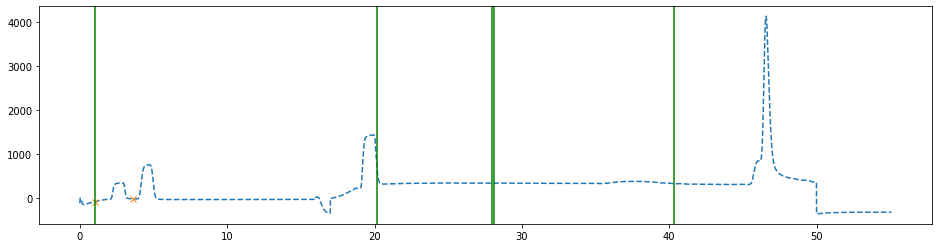

In [36]:
index = 170
intensities = intensities_array[index]
labels = labels_array[index]
peak_start_times = times[labels==1]
peak_start_intensities = intensities[labels==1]
predictions_per_data = predictions[index]
predicted_peak_start_times = times[predictions_per_data > 0.12]

plt.figure(figsize=(16,4))
plt.plot(
    times, intensities, '--',
    peak_start_times, peak_start_intensities, 'x'
)
for predicted_peak_start_time in predicted_peak_start_times:
    plt.axvline(x=predicted_peak_start_time, color='green')